<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Long Short Term Memory (LSTM)

###Install dependencies

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00


###Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle
import random as python_random

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define a function to get reproducable results in keras

In [3]:
def reset_seeds():
   np.random.seed(123) 
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds() 

###Define Functions to Facilitate Metrics Evaluation

In [4]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [5]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [6]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [7]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [8]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

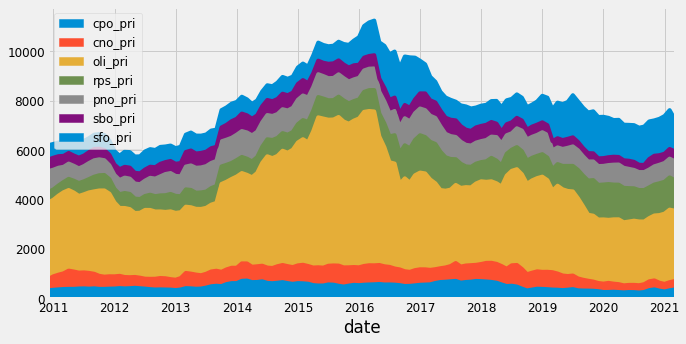

In [9]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Long Short Term Memory Forecasting Technique (LSTM)**

###**Split Data into Train Test Segments**

In [10]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [11]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [12]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [13]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [14]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [15]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [16]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [17]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [18]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


###LSTM Baseline Model Architecture


*  LSTM with 85 neurons in the first visible layer.
*  LSTM with 64 neurons in the second visible layer.
*  1 neuron in the output layer for predicting crude palm oil price.
*  The input shape will be 3 time step with 7 features.
*   I apply the Mean Squared Error (MSE) loss function and the efficient Adam version of stochastic gradient descent.
*  Fit the model for 100 training epochs with a batch size of 64.


In [19]:
LSTM_model = tf.keras.Sequential()
LSTM_model.add(tf.keras.layers.LSTM(units=85, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
LSTM_model.add(tf.keras.layers.Dense(64, activation='tanh'))
LSTM_model.add(tf.keras.layers.Dense(1))

# compile model using adam
LSTM_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 64, validation_split=0.2) #epochs = 30, batch_size = 60

# model evaluation
LSTM_model.evaluate(X_test, y_test)

Epoch 1/100
2/2 [==============================] - 8s 523ms/step - loss: 0.5491 - mse: 0.5491 - val_loss: 0.4791 - val_mse: 0.4791
Epoch 2/100
2/2 [==============================] - 0s 49ms/step - loss: 0.3400 - mse: 0.3400 - val_loss: 0.3058 - val_mse: 0.3058
Epoch 3/100
2/2 [==============================] - 0s 49ms/step - loss: 0.1976 - mse: 0.1976 - val_loss: 0.1818 - val_mse: 0.1818
Epoch 4/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0912 - mse: 0.0912 - val_loss: 0.1017 - val_mse: 0.1017
Epoch 5/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0639 - val_mse: 0.0639
Epoch 6/100
2/2 [==============================] - 0s 36ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0618 - val_mse: 0.0618
Epoch 7/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0718 - val_mse: 0.0718
Epoch 8/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0566 - mse: 0.0

[0.01166661735624075, 0.01166661735624075]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


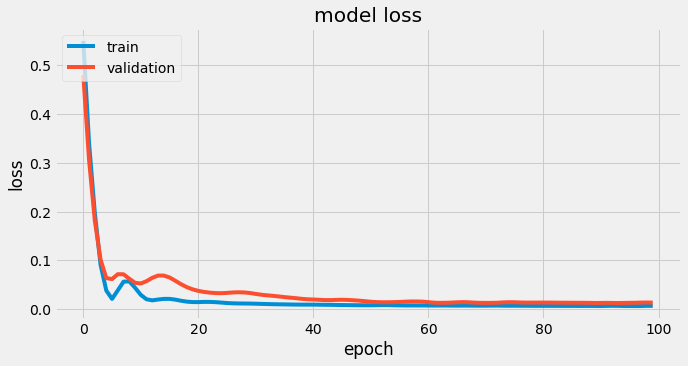

In [21]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
mse_LSTM = LSTM_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 28ms/step - loss: 0.0117 - mse: 0.0117


####Baseline LSTM MSE = 0.0117

In [23]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 85)                31620     
                                                                 
 dense (Dense)               (None, 64)                5504      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37,189
Trainable params: 37,189
Non-trainable params: 0
_________________________________________________________________


###Predict the Test without Hyperparameter Tuning

In [24]:
y_pred = LSTM_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 401ms/step


array([[ 0.08518687],
       [ 0.08238669],
       [ 0.09892457],
       [ 0.08891709],
       [ 0.06455392],
       [ 0.03670273],
       [ 0.02719714],
       [ 0.00633782],
       [-0.02570586],
       [-0.04731761],
       [-0.05583984],
       [-0.05854325],
       [-0.06982498],
       [-0.07122274],
       [-0.06871042],
       [-0.08035269],
       [-0.08961333],
       [-0.02344392],
       [ 0.06631437],
       [ 0.09942459],
       [ 0.06272436],
       [ 0.04892148]], dtype=float32)

In [25]:
y_pred.reshape(1,-1)

array([[ 0.08518687,  0.08238669,  0.09892457,  0.08891709,  0.06455392,
         0.03670273,  0.02719714,  0.00633782, -0.02570586, -0.04731761,
        -0.05583984, -0.05854325, -0.06982498, -0.07122274, -0.06871042,
        -0.08035269, -0.08961333, -0.02344392,  0.06631437,  0.09942459,
         0.06272436,  0.04892148]], dtype=float32)

###Invert Transformed Data

In [26]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[353.07474 351.95468 358.56982 354.56683 344.82156 333.6811  329.87885
  321.53513 308.71765 300.07297 296.66406 295.5827  291.07    290.5109
  291.51584 286.85892 283.15466 309.62244 345.52576 358.76984 344.08975
  338.5686 ]]


###Plot History, Actual and Predicted Value

In [27]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [28]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [29]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([353.07474, 351.95468, 358.56982, 354.56683, 344.82156, 333.6811 ,
       329.87885, 321.53513, 308.71765, 300.07297, 296.66406, 295.5827 ,
       291.07   , 290.5109 , 291.51584, 286.85892, 283.15466, 309.62244,
       345.52576, 358.76984, 344.08975, 338.5686 ], dtype=float32)

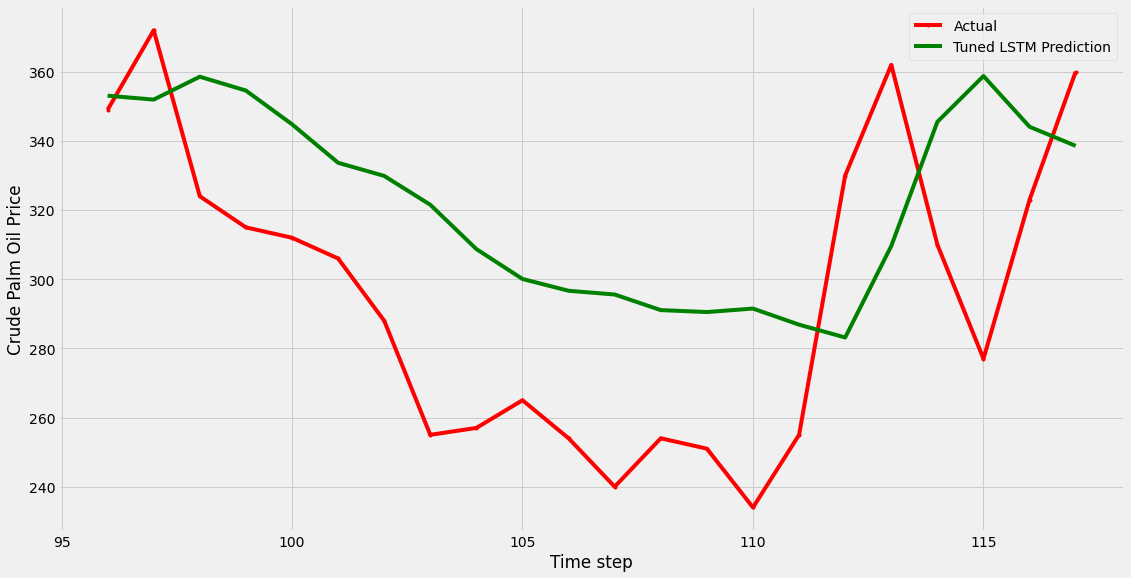

In [30]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='green', label="Tuned LSTM Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
plt.savefig('graph_LSTM.png')

###Evaluate LSTM Model Accuracy

In [31]:
MAE_LSTM = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the LSTM Model is:', MAE_LSTM)

MDA_LSTM = mda(y_test_inv, y_pred_inv)
print('MDA value of the LSTM Model is:', MDA_LSTM)

MAPE_LSTM = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the LSTM Model is:', MAPE_LSTM)

RMSE_LSTM = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the LSTM Model is:', RMSE_LSTM)

MSE_LSTM = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the LSTM Model is:', MSE_LSTM)

#EVS_LSTM = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the LSTM Model is:', EVS_LSTM)

MAE value of the LSTM Model is: 39.87300109863281
MDA value of the LSTM Model is: 0.42857142857142855
MAPE value of the LSTM Model is: 14.21985046092596
RMSE value of the LSTM Model is: 43.20484645537478
MSE value of the LSTM Model is: 1866.6587572325107


###Tuning LSTM with Keras Tuner

Define A Model-Building Class

In [32]:
#class ANNhypermodel(HyperModel):
class LSTMHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
        hp_units_1= hp.Int('units_1', min_value=64, max_value= 256, step=16)
        hp_units_2= hp.Int('units_2', min_value=32, max_value= 128, step=16)
        #hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)
        #hp_units_4= hp.Int('units_4', min_value=16, max_value= 32, step=8)

        model.add(keras.layers.Dense(units=hp_units_1, input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2))
        #model.add(keras.layers.Dense(units=hp_units_3))
        #model.add(keras.layers.Dense(units=hp_units_4))
        model.add(keras.layers.Dense(1))
        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        
        
        optimizers = hp.Choice('optimizer',values=['rmsprop','adam', 'nadam','sgd','adadelta','adagrad'])
        

        # Tune the activation
        hp_dense_activation = hp.Choice('activation',values=['relu', 'tanh', 'sigmoid', 'linear', 'Softmax', 'ELU', 'linear'])

        # Tune the batch size for the optimizer 
        hp_batch_size = hp.Int('batch_size', min_value = 8, max_value = 96, step = 8, default=8)
        
        # Tune the epoch for the optimizer
        hp_epoch = hp.Int('epoch', min_value = 5, max_value = 100, step = 5, default=5)

        # Tune the epoch for the momentum
        hp_momentum = hp.Float('momentum', min_value = 0.8, max_value = 0.99, step = 0.01, default=0.9)

        # Tune the epoch for the decay
        hp_decay = hp.Float('decay', min_value = 1e-9, max_value = 1e-3, step= 0.0001, default=1e-7)

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

#hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
hypermodel = LSTMHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Applying Keras Tuner to Get Best LSTM Hyperparameters

* Instantiate the tuner to use Random Search
* Instantiate the tuner to use Hyperband
* Compare Random Search and Hyperband for the one with the smallest MSE score.
* Get optimal hyperparameters from the tuner. 
* Apply the optimal hyperparameters to the LSTM.

###Build Random Search Tuner

In [33]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [34]:
tuner_rs.search(X_train, y_train, epochs=16, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [35]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 299ms/step - loss: 0.1884 - mae: 0.4204 - mse: 0.1884


####Random Search MSE =  0.1884

In [36]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 144,
 'units_2': 80,
 'dropout': 0.2,
 'optimizer': 'adadelta',
 'activation': 'Softmax',
 'batch_size': 8,
 'epoch': 20,
 'momentum': 0.8,
 'decay': 0.000700001,
 'learning_rate': 0.001083033272419774}

###Build HYPERBAND optimization

In [ ]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [ ]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [ ]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


1412.1860146522522  secs


In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 

drop out is {best_hps.get('dropout')}
batch_size is {best_hps.get('batch_size')}
epoch is {best_hps.get('epoch')}
optimizer is {best_hps.get('optimizer')}
activation is {best_hps.get('activation')}

momentum is {best_hps.get('momentum')}
decay is {best_hps.get('decay')}

#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 192,
second layer is 80 

drop out is 0.25
batch_size is 48
epoch is 20
optimizer is nadam
activation is linear

momentum is 0.91
decay is 0.0006000010000000001

#learning rate is 0.003902784327745087                                        

and the optimal learning rate for the optimizer
is 0.003902784327745087.

[]
1/1 [==============================] - 0s 482ms/step - loss: 0.0113 - mae: 0.0947 - mse: 0.0113
loss:0.011347240768373013 mae: 0.09473496675491333 mse: 0.011347240768373013


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 192, 'units_2': 80, 'dropout': 0.25, 'optimizer': 'nadam', 'activation': 'linear', 'batch_size': 48, 'epoch': 20, 'momentum': 0.91, 'decay': 0.0006000010000000001, 'learning_rate': 0.003902784327745087, 'tuner/epochs': 6, 'tuner/initial_epoch': 2, 'tuner/bracket': 4, 'tuner/round': 1, 'tuner/trial_id': '0059'}


* The Hyperband MSE is lower than the Random search MSE.
* So we apply the optimal hyperparameters obtained from the Hyperband to the LSTM.

###Applying the trained parameters to the LSTM

In [43]:
TULSTM_model = tf.keras.Sequential()
TULSTM_model.add(tf.keras.layers.LSTM(units=192, activation='linear', input_shape=(X_test.shape[1], X_test.shape[2])))
TULSTM_model.add(tf.keras.layers.Dense(80, activation='linear'))
TULSTM_model.add(Dropout(0.25))
TULSTM_model.add(tf.keras.layers.Dense(1, 'linear'))

In [44]:
TULSTM_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.legacy.Nadam(learning_rate=0.0039027, decay = 0.00060), metrics= ['mae', 'mse'])
history = TULSTM_model.fit(X_train, y_train, epochs=20, batch_size=48,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/20
2/2 [==============================] - 2s 274ms/step - loss: 0.1501 - mae: 0.3193 - mse: 0.1501 - val_loss: 0.1446 - val_mae: 0.3123 - val_mse: 0.1446
Epoch 2/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0544 - mae: 0.1734 - mse: 0.0544 - val_loss: 0.0382 - val_mae: 0.1729 - val_mse: 0.0382
Epoch 3/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0180 - mae: 0.1062 - mse: 0.0180 - val_loss: 0.0418 - val_mae: 0.1772 - val_mse: 0.0418
Epoch 4/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0169 - mae: 0.1038 - mse: 0.0169 - val_loss: 0.0317 - val_mae: 0.1556 - val_mse: 0.0317
Epoch 5/20
2/2 [==============================] - 0s 56ms/step - loss: 0.0148 - mae: 0.0983 - mse: 0.0148 - val_loss: 0.0313 - val_mae: 0.1543 - val_mse: 0.0313
Epoch 6/20
2/2 [==============================] - 0s 55ms/step - loss: 0.0140 - mae: 0.0915 - mse: 0.0140 - val_loss: 0.0323 - val_mae: 0.1519 - val_mse: 0.0323
Epoch 7/20
2/2 [=================

Plot Model Loss

<Figure size 720x360 with 0 Axes>

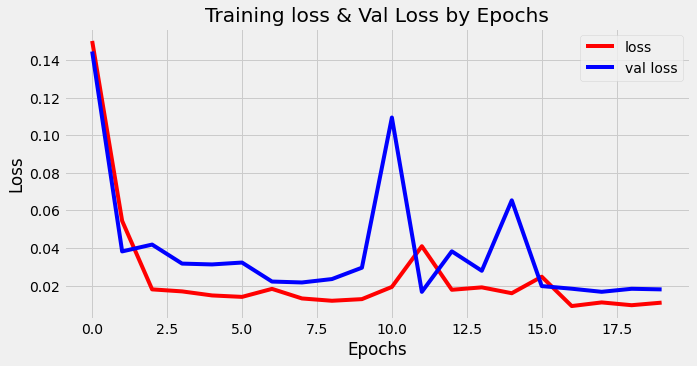

<Figure size 720x360 with 0 Axes>

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure()

In [46]:
y_predTU = TULSTM_model.predict(X_test)
y_predTU

1/1 [==============================] - 0s 147ms/step


array([[ 0.04261754],
       [ 0.03645389],
       [ 0.0558711 ],
       [ 0.04047306],
       [ 0.01280571],
       [-0.01190772],
       [-0.02381866],
       [-0.04641825],
       [-0.08081897],
       [-0.09839413],
       [-0.09894063],
       [-0.09880672],
       [-0.1105222 ],
       [-0.11149734],
       [-0.11190102],
       [-0.13015626],
       [-0.14069095],
       [-0.06362236],
       [ 0.02801204],
       [ 0.05237891],
       [ 0.01196525],
       [-0.0003089 ]], dtype=float32)

In [47]:
y_predTU.reshape(1,-1)

array([[ 0.04261754,  0.03645389,  0.0558711 ,  0.04047306,  0.01280571,
        -0.01190772, -0.02381866, -0.04641825, -0.08081897, -0.09839413,
        -0.09894063, -0.09880672, -0.1105222 , -0.11149734, -0.11190102,
        -0.13015626, -0.14069095, -0.06362236,  0.02801204,  0.05237891,
         0.01196525, -0.0003089 ]], dtype=float32)

###Invert Transformed Tuned Data

In [48]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[336.047   333.58157 341.34842 335.1892  324.12228 314.2369  309.47253
  300.4327  286.6724  279.64233 279.42377 279.4773  274.7911  274.40106
  274.2396  266.9375  262.7236  293.55106 330.20483 339.95157 323.7861
  318.87643]]


In [49]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [50]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [51]:
TU_LSTM_Pred = y_pred_inv.flatten()   #y_pred_inv = TU_LSTM_Pred
TU_LSTM_Pred

array([336.047  , 333.58157, 341.34842, 335.1892 , 324.12228, 314.2369 ,
       309.47253, 300.4327 , 286.6724 , 279.64233, 279.42377, 279.4773 ,
       274.7911 , 274.40106, 274.2396 , 266.9375 , 262.7236 , 293.55106,
       330.20483, 339.95157, 323.7861 , 318.87643], dtype=float32)

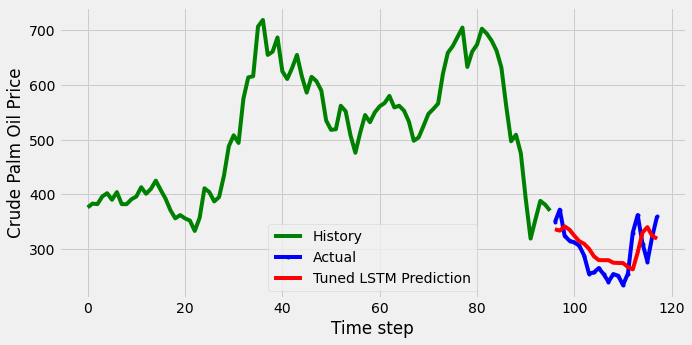

In [52]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_LSTM_Pred, color='red', label="Tuned LSTM Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();

In [53]:
TUMAE_LSTM = mean_absolute_error(y_test_inv, TU_LSTM_Pred)
print('MAE value of the LSTM Model is:', TUMAE_LSTM)

TUMDA_LSTM = mda(y_test_inv, TU_LSTM_Pred)
print('MDA value of the tuned LSTM Model is:', TUMDA_LSTM)

TUMAPE_LSTM = mean_absolute_percentage_error(y_test_inv, TU_LSTM_Pred)
print('MAPE value of the tuned LSTM Model is:', TUMAPE_LSTM)

TURMSE_LSTM = mean_squared_error(y_test_inv,TU_LSTM_Pred, squared=False)
print('RMSE value of the tuned LSTM Model is:', TURMSE_LSTM)

TUMSE_LSTM = mean_squared_error(y_test_inv,TU_LSTM_Pred)
print('MSE value of the tuned LSTM Model is:', TUMSE_LSTM)

MAE value of the LSTM Model is: 29.206816239790484
MDA value of the tuned LSTM Model is: 0.42857142857142855
MAPE value of the tuned LSTM Model is: 10.035175957228775
RMSE value of the tuned LSTM Model is: 34.646185403913876
MSE value of the tuned LSTM Model is: 1200.3581630423748


Compare tuned LSTM Actual VS Predicted (Zoomed-IN)

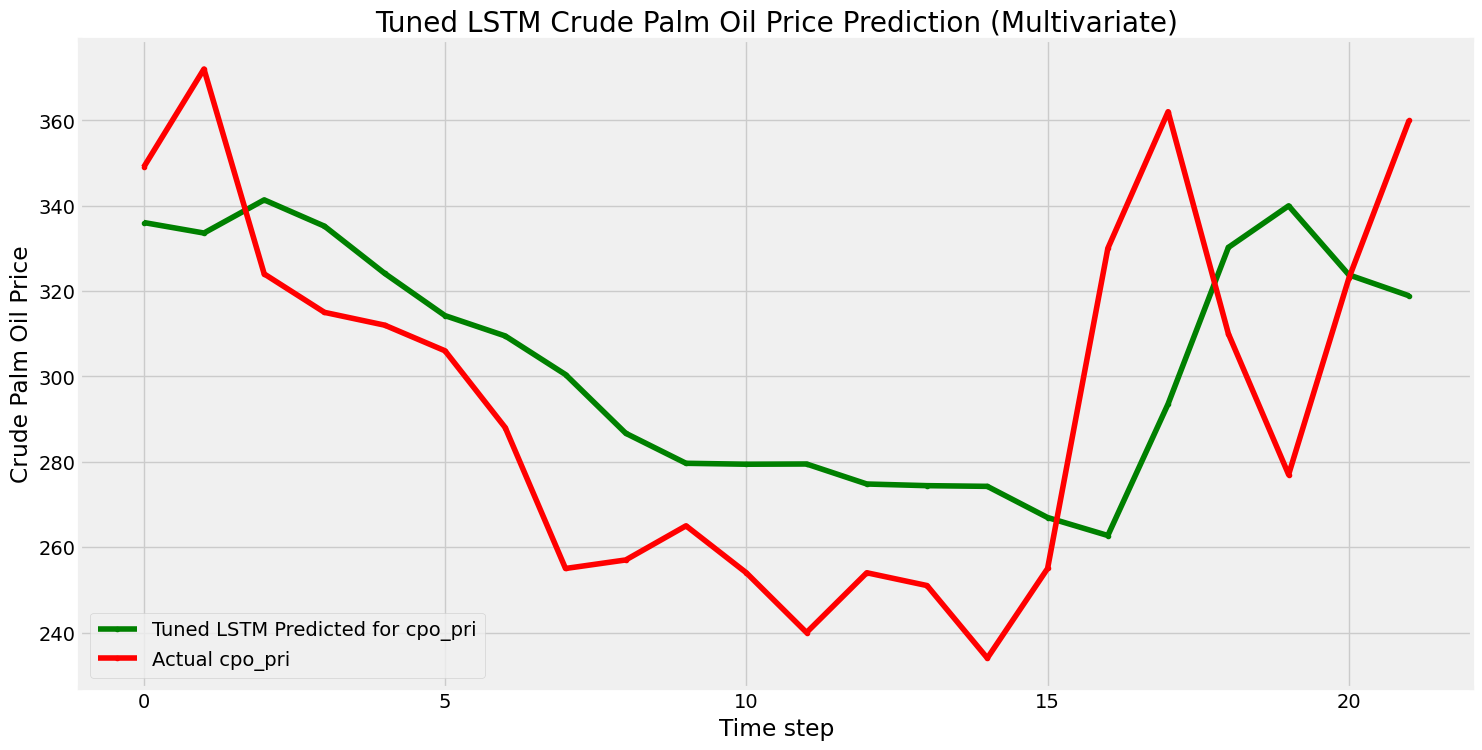

<Figure size 720x360 with 0 Axes>

In [54]:
#Plot the graph between actual vs predicted values
#plt.figure(figsize=(15,7))  #(10,6))
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(TU_LSTM_Pred, color= 'green',marker='.',label = 'Tuned LSTM Predicted for cpo_pri')
plt.plot(y_test_inv, color = 'red',marker='.',label = 'Actual cpo_pri ')
plt.title("Tuned LSTM Crude Palm Oil Price Prediction (Multivariate)")
plt.xlabel("Time step")
plt.ylabel("Crude Palm Oil Price")
plt.legend()
plt.show()
plt.savefig('graph_TULSTM.png')

##Results

Baseline (LSTM)  MSE             = 0.0117

Random search MSE                = 0.1884

Hyperband search MSE             = 0.0113

Baseline (LSTM) RMSE             = 43.20

Optimized (Tuned) LSTM RMSE      = 34.64

The tuned LSTM is superior to the basseline based on the RMSE result

In [ ]:
TU_LSTM_Pred

array([339.00253, 335.65112, 344.22235, 337.79007, 325.9214 , 315.51358,
       311.50143, 302.6391 , 287.85272, 279.78906, 278.92062, 278.5172 ,
       273.70206, 274.2276 , 275.2922 , 267.42203, 262.01678, 297.70624,
       339.54272, 350.98715, 332.32074, 326.4153 ], dtype=float32)